In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM, _SwitchingLDS
from ssm.variational import SLDSTriDiagVariationalPosterior
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations
from ssm.emissions import GaussianEmissions

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify outputs
results_dir = "results/kato/2018-11-07"

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [4]:
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input

# Dimensionality reduction on $\Delta$F/F 

In [5]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)
# xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
# dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

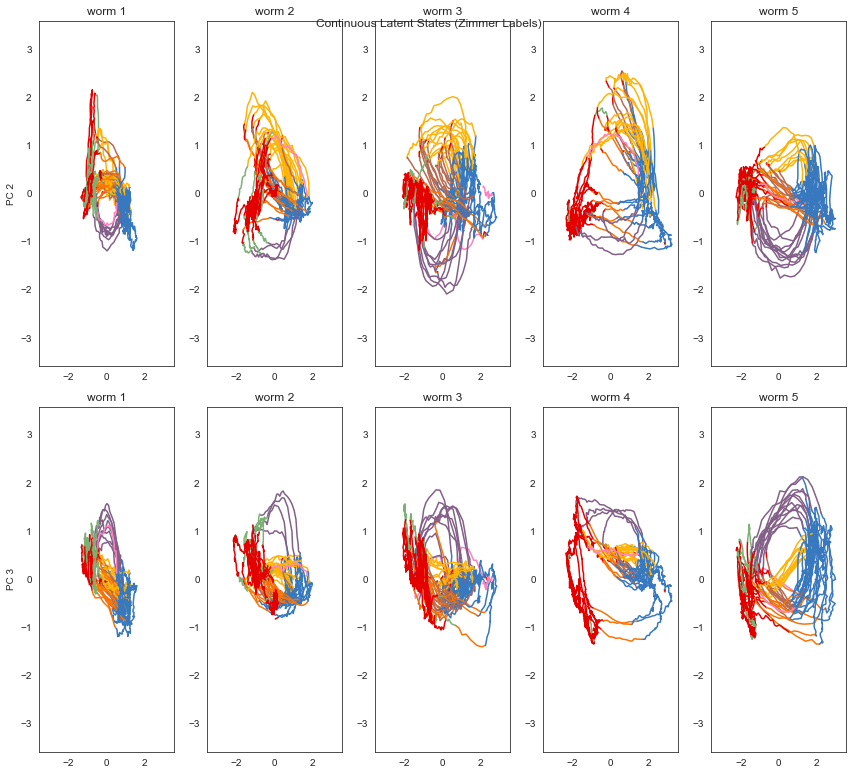

In [6]:
plt.figure(figsize=(12, 16))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    for d in range(1, 3):
        ax = plt.subplot(3, W, (d-1) * W + w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if w == 0 else "")
        plt.title("worm {}".format(w+1))

plt.suptitle("Continuous Latent States (Zimmer Labels)")
plt.tight_layout()

# Split into train/test/validation

In [7]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [8]:
print("Training chunks per worm:   ", np.bincount(train_tags))
print("Validation chunks per worm: ", np.bincount(val_tags))
print("Testing chunks per worm:    ", np.bincount(test_tags))

Training chunks per worm:    [9 9 9 9 9]
Validation chunks per worm:  [2 2 2 2 2]
Testing chunks per worm:     [2 2 2 2 2]


# Fit a recurrent SLDS

In [9]:
K = 8

# Construct the SLDS components
# transitions = "recurrent"
# dynamics = "robust_ar"
# init_state_distn = InitialStateDistribution(K, D, M)

# transition_classes = dict(recurrent=HierarchicalRecurrentTransitions)
# transition_distn = transition_classes[transitions](K, D, W, M, eta=1e-4)

# dynamics_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
#                         independent_ar=HierarchicalIndependentAutoRegressiveObservations,
#                         robust_ar=HierarchicalRobustAutoRegressiveObservations)
# dynamics_distn = dynamics_classes[dynamics](K, D, W, M, eta=1e-4)

# Construct the HMM
initial_state = InitialStateDistribution(K, D, M)
transitions = HierarchicalRecurrentTransitions(K, D, range(W), M, eta=1e-4)
dynamics = HierarchicalRobustAutoRegressiveObservations(K, D, range(W), M, eta=1e-4)
emissions = GaussianEmissions(N, K, D, M)
rslds = _SwitchingLDS(N, K, D, M, initial_state, transitions, dynamics, emissions)
rslds.initialize(train_ys, masks=train_ms, tags=train_tags)

Initializing with an ARHMM using 25 steps of EM.


In [11]:
# Fit
variational_posterior = SLDSTriDiagVariationalPosterior(rslds, train_ys, masks=train_ms, tags=train_tags)
elbos = rslds.fit(variational_posterior, train_ys, masks=train_ms, tags=train_tags, 
                  method="svi", initialize=False, num_iters=1000)

KeyboardInterrupt: 

In [ ]:
plt.plot(elbos)

In [ ]:
# Validate
val_elbos, _ = slds.approximate_posterior(val_ys, masks=val_ms, tags=val_tags)

# Fit the SLDS to the full train and validation data

In [ ]:
full_elbos, variational_params = slds.approximate_posterior(ys, masks=ms, tags=list(range(W)))

# Unpack the variational parameters

In [ ]:
q_mus = [vp[0] for vp in variational_params]
q_vars = [vp[1] for vp in variational_params]

# Look at inferred state segmentations

In [ ]:
z_infs = [slds.most_likely_states(q_mu, y, tag=tag) for tag, (q_mu, y) in enumerate(zip(q_mus, ys))]
slds.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [slds.most_likely_states(q_mu, y, tag=tag) for tag, (q_mu, y) in enumerate(zip(q_mus, ys))]

In [ ]:
np.bincount(np.concatenate(z_infs), minlength=8)

In [ ]:
zplt.plot_latent_trajectories_vs_time(q_mus, z_infs, plot_slice=(0, 1000))

In [ ]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(q_mus, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.xlabel("PC 1")
    plt.title("worm {}".format(w+1))
    

In [ ]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(q_mus, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")

In [ ]:
# if D > 3:
#     plt.figure(figsize=(12, 3))
#     for w, (x, z) in enumerate(zip(xs, z_infs)):    
#         ax = plt.subplot(1, W, w+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
#         plt.ylabel("PC 4" if w == 0 else "")
#         plt.xlabel("PC 1")    
#         plt.title("worm {}".format(w+1))

In [ ]:
# if D > 4:
#     plt.figure(figsize=(12, 3))
#     for w, (x, z) in enumerate(zip(xs, z_infs)):
#         ax = plt.subplot(1, W, w+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 4), ax=ax)
#         plt.ylabel("PC 5" if w == 0 else "")
#         plt.xlabel("PC 1")    
#         plt.title("worm {}".format(w+1))  

In [ ]:
# if D > 5:
#     plt.figure(figsize=(12, 3))
#     for w, (x, z) in enumerate(zip(xs, z_infs)):  
#         ax = plt.subplot(1, W, w+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 5), ax=ax)
#         plt.ylabel("PC 6" if w == 0 else "")
#         plt.xlabel("PC 1")    
#         plt.title("worm {}".format(w+1))

#     plt.suptitle("Continuous Latent States (Zimmer Labels)")

# Compare inferred and manually labeled states

In [ ]:
zplt.plot_state_overlap(z_infs, z_trues)

In [ ]:
# Helper function to find overlap percentages
def compute_pct_overlap(zi, ztr):
    overlap = np.zeros((best_hhmm_K, K_true))
    for k in range(best_hhmm_K):
        overlap[k] = np.bincount(ztr[zi == k], minlength=K_true).astype(float)
        overlap[k] /= (overlap[k].sum() + 1e-3)
    return overlap

# Find a permutation so that the bar codes look progressive
total_overlap = compute_pct_overlap(np.concatenate(z_infs), np.concatenate(z_trues))
overlap_perm = np.argsort(np.argmax(total_overlap, axis=1))

# Helper function to plot "barcodes"
from matplotlib.cm import get_cmap
zimmer_colors = get_cmap("cubehelix")(np.linspace(0, 1, K_true))
def plot_overlap_barcode(ax, overlap):
    for i,k in enumerate(overlap_perm):        
        for ktr in range(K_true):
            plt.bar(i, overlap[k, ktr], bottom=np.sum(overlap[k, :ktr]), color=zimmer_colors[ktr], width=0.8)
    ax.set_xlim(-.5, best_hhmm_K-.5)
    
# Plot all overlaps as bar codes
plt.figure(figsize=(12, 4))

# Plot the total overlap first
ax = plt.subplot(1, W+1, 1)
plot_overlap_barcode(ax, total_overlap)
plt.ylabel("Pct of manual state")
plt.yticks([0, .25, .5, .75, 1], [0, 25, 50, 75, 100])
plt.ylim(0, 1)
plt.xlabel("Inferred state")
plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
plt.title("All worms")

for w in range(W):
    ax = plt.subplot(1, W+1, w+2)
    overlap_w = compute_pct_overlap(z_infs[w], z_trues[w])
    plot_overlap_barcode(ax, overlap_w)
    plt.yticks([])        
    plt.ylim(0, 1)
    plt.xlabel("Inferred state")
    plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
    plt.title("Worm {}".format(w+1))
plt.tight_layout()

# Print key
for color_name, state_name in zip(zplt.color_names, z_true_key):
    print("{} : {}".format(color_name, state_name))

# Simulate from an HMM, reducing the dynamics noise

In [ ]:
hhmm_low_noise = copy.deepcopy(hhmm)
hhmm_low_noise.observations.inv_sigmas -= 4

In [ ]:
pad = 3

zsmpls = []
xsmpls = []
ysmpls = []

for w in range(W):
    # Sample data
    Tsmpl = Ts[w]
    zpre, xpre = z_infs[w][-pad:], xs[w][-pad:]
    zsmpl, xsmpl = hhmm_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=w, with_noise=True)

    zsmpl = np.concatenate((zpre, zsmpl))
    xsmpl = np.concatenate((xpre, xsmpl))
    
    # Truncate to stable region
    unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 5, axis=1)]
    T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
    zsmpl = zsmpl[:T_stable]
    xsmpl = xsmpl[:T_stable]
    
    # Project into neural space
    ysmpl = xsmpl.dot(pca.components_) + pca.mean_
    
    # Append
    zsmpls.append(zsmpl)
    xsmpls.append(xsmpl)
    ysmpls.append(ysmpl)

In [ ]:
# Plot continuous latent states
for w, (zsmpl, xsmpl) in enumerate(zip(zsmpls, xsmpls)):
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 2, 1, aspect="equal")
    zplt.plot_2d_continuous_states(xsmpl, zsmpl, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.plot(xsmpl[pad-1,0], xsmpl[pad-1,1], 'k*')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Worm {}".format(w + 1))

    ax = plt.subplot(1, 2, 2, aspect="equal")
    zplt.plot_2d_continuous_states(xsmpl, zsmpl, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.plot(xsmpl[pad-1,0], xsmpl[pad-1,2], 'k*')
    plt.xlabel("PC 1")
    plt.ylabel("PC 3")
    plt.title("Worm {}".format(w + 1))

In [ ]:
for w, ysmpl in enumerate(ysmpls):
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(ysmpl.shape[0]) / 3.0, ysmpl - np.arange(N), '-k')
    plt.yticks(-np.arange(N), neuron_names)
    plt.ylim(-N,1)
    plt.xlim(0, Ts[w] / 3.0)
    plt.xlabel("time (s)")
    plt.title("Simulated Worm {}".format(w + 1))
    
    # Plot real data for comparison
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(Ts[w]) / 3.0, (ys[w] - np.arange(N)) * ms[w], '-', color=zplt.default_colors[3])
    plt.yticks(-np.arange(N), neuron_names)
    plt.ylim(-N,1)
    plt.xlim(0, Ts[w] / 3.0)
    plt.xlabel("time (s)")
    plt.title("Real Worm {}".format(w + 1))
    
    plt.pause(.1)